In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from joblib import dump, load
import torch

In [2]:
a = torch.tensor([1, 2, 3.0], dtype=torch.float32, device='cuda')
a

/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


tensor([1., 2., 3.], device='cuda:0')

In [30]:
# rf_st = load("/opt/aqmsp_models/models/config_all/rf_st/cpcb_ijcai24_dec23/config1/fold_1/model.joblib")

In [31]:
# # get feature importances
# feature_importances = rf_st.feature_importances_
# # print(feature_importances)
# feature_names = rf_st.feature_names_in_
# imp_dict = {feature_names[i]: feature_importances[i] for i in range(len(feature_importances))}
# # sort the dictionary
# sorted_dict = dict(sorted(imp_dict.items(), key=lambda item: item[1], reverse=True))
# sorted_dict

In [32]:
"""
{'TEMP_K_LAY0': 0.11381127474900354,
 'ZGRID_M_LAY19': 0.10035205070775434,
 'pop_5km': 0.09866707267358009,
 'dayofweek': 0.05448821273204932,
 'UWIND_MpS_3d': 0.0447985787424111,
 'd_motorway': 0.04164070473729576,
 'SOLM_M3pM3': 0.041637045009890454,
 'HUMID_PPM_LAY19': 0.03797726885608965,
 'pop_10km': 0.03778175788397258,
 'VWIND_MpS_LAY19': 0.0339044459172877,
 'TEMP_K_LAY19': 0.030137376253815927,
 'HUMID_PPM_3d': 0.029919699452646453,
 'VWIND_MpS_3d': 0.029814241401494742,
 'UWIND_MpS_LAY19': 0.028952382954997212,
"""

"\n{'TEMP_K_LAY0': 0.11381127474900354,\n 'ZGRID_M_LAY19': 0.10035205070775434,\n 'pop_5km': 0.09866707267358009,\n 'dayofweek': 0.05448821273204932,\n 'UWIND_MpS_3d': 0.0447985787424111,\n 'd_motorway': 0.04164070473729576,\n 'SOLM_M3pM3': 0.041637045009890454,\n 'HUMID_PPM_LAY19': 0.03797726885608965,\n 'pop_10km': 0.03778175788397258,\n 'VWIND_MpS_LAY19': 0.0339044459172877,\n 'TEMP_K_LAY19': 0.030137376253815927,\n 'HUMID_PPM_3d': 0.029919699452646453,\n 'VWIND_MpS_3d': 0.029814241401494742,\n 'UWIND_MpS_LAY19': 0.028952382954997212,\n"

In [47]:
target = "PM2.5"
dataset = "cpcb_ijcai24_dec23"
res_dict = {}
# for config in ["config_s", "config_sp1", "config_p1", "config_se", "config_st", "config_sw", "config_sh", "config_std", "config_sp3", "config_sall", "config_sp3r", "config_sco", "config_sno2", "config_sso2", "config_sopt", "config_all", "config_sopt"]:
for config in ["config_s", "config_s1", "config_s2", "config_s2pr", "config_s2p"]:
# for config in ["no2_config_s", "config_sp1", "config_p1", "config_se", "config_st", "config_sw", "config_sh", "config_std", "no2_config_sp3"]:
    # for model in ["lr", "mean", "rf", "1nn", "idw", "kriging", "deeptime", "zcnp", "convgnp"]:
    for model in ["rf_st", "nn_st", "mean", "rf", "idw", "1nn", "kriging", "siren", "gpr", "adain", "deeptime", "anp"]:
        if model in ["mean", "idw", "1nn", "kriging"] and not config.endswith("config_s"):
            continue
        res_dict[f"{model}_{config}"] = {}
        for fold in range(4):
            try:
                with xr.open_dataset(f"/opt/aqmsp_models/models/{config}/{model}/{dataset}/config1/fold_{fold}/predictions.nc") as res_ds:
                    pass
                # print(res_ds)
                # select ds with non-nan values
                res_df = res_ds.to_dataframe().reset_index()
                res_df = res_df[res_df[f"{target}_missing"] == False]
                # target_pred shouldn't be nan
                res_df = res_df[~res_df[f"{target}"].isna()]
                res_df = res_df[~res_df[f"{target}_pred"].isna()]
                rmse = np.sqrt(np.mean((res_df[target].values - res_df[f"{target}_pred"].values)**2))
                res_dict[f"{model}_{config}"][fold] = rmse
                # print(res_df[f"{target}_pred"].head(5), rmse)
                # rmse = res_df.groupby("station").apply(lambda x: np.sqrt(np.mean((x[target] - x[f"{target}_pred"])**2))).mean()
                # res_dict[f"{model}_{config}"][fold] = rmse
            except Exception as e:
                # print(f"Error: {e}")
                res_dict[f"{model}_{config}"][fold] = np.nan
        
df = pd.DataFrame(res_dict).T
df["mean"] = df.mean(axis=1)
df.sort_values("mean", inplace=True)
# df.index = df.index.str.replace("_config_s", "")
print(df.head(12).style.format("{:.2f}").to_latex())

\begin{tabular}{lrrrrr}
 & 0 & 1 & 2 & 3 & mean \\
kriging_config_s & 53.80 & 49.57 & 49.04 & 71.17 & 55.89 \\
rf_config_s2pr & 53.71 & 50.75 & 52.25 & 69.84 & 56.64 \\
anp_config_s2pr & 54.49 & 54.85 & 55.20 & 62.78 & 56.83 \\
idw_config_s & 55.16 & 48.77 & 51.80 & 73.01 & 57.18 \\
anp_config_s2p & 54.16 & 57.15 & 51.55 & 66.30 & 57.29 \\
rf_config_s2 & 55.09 & 51.07 & 52.55 & 75.62 & 58.58 \\
anp_config_s1 & 55.17 & 51.70 & 50.57 & 78.62 & 59.02 \\
rf_config_s & 53.66 & 50.62 & 54.73 & 78.22 & 59.31 \\
anp_config_s2 & 57.00 & 51.74 & 51.76 & 82.03 & 60.63 \\
anp_config_s & 57.08 & 52.45 & 50.19 & 88.15 & 61.97 \\
mean_config_s & 58.36 & 59.19 & 59.13 & 73.10 & 62.45 \\
1nn_config_s & 73.21 & 60.23 & 65.47 & 81.56 & 70.12 \\
\end{tabular}



In [34]:
target = "PM2.5"
dataset = "cpcb_ijcai24_dec23"
res_dict = {}
# for config in ["config_s", "config_sp1", "config_p1", "config_se", "config_st", "config_sw", "config_sh", "config_std", "config_sp3", "config_sall", "config_sp3r", "config_sco", "config_sno2", "config_sso2", "config_sopt", "config_all", "config_sopt"]:
for config in ["config_s", "config_s1", "config_s2", "config_s2pr", "config_s2p"][2:3]:
# for config in ["no2_config_s", "config_sp1", "config_p1", "config_se", "config_st", "config_sw", "config_sh", "config_std", "no2_config_sp3"]:
    # for model in ["lr", "mean", "rf", "1nn", "idw", "kriging", "deeptime", "zcnp", "convgnp"]:
    for model in ["rf_st", "nn_st", "mean", "rf", "idw", "1nn", "kriging", "siren", "gpr", "adain", "deeptime", "anp"]:
        if model in ["mean", "idw", "1nn", "kriging"] and not config.endswith("config_s"):
            continue
        res_dict[f"{model}_{config}"] = {}
        for fold in range(4):
            try:
                with xr.open_dataset(f"/opt/aqmsp_models/models/{config}/{model}/{dataset}/config1/fold_{fold}/predictions.nc") as res_ds:
                    pass
                # print(res_ds)
                # select ds with non-nan values
                res_df = res_ds.to_dataframe().reset_index()
                res_df = res_df[res_df[f"{target}_missing"] == False]
                # target_pred shouldn't be nan
                res_df = res_df[~res_df[f"{target}"].isna()]
                res_df = res_df[~res_df[f"{target}_pred"].isna()]
                rmse = np.sqrt(np.mean((res_df[target].values - res_df[f"{target}_pred"].values)**2))
                res_dict[f"{model}_{config}"][fold] = rmse
                # print(res_df[f"{target}_pred"].head(5), rmse)
                # rmse = res_df.groupby("station").apply(lambda x: np.sqrt(np.mean((x[target] - x[f"{target}_pred"])**2))).mean()
                # res_dict[f"{model}_{config}"][fold] = rmse
            except Exception as e:
                # print(f"Error: {e}")
                res_dict[f"{model}_{config}"][fold] = np.nan
        
df = pd.DataFrame(res_dict).T
df["mean"] = df.mean(axis=1)
df.sort_values("mean", inplace=True)
df.index = df.index.str.replace("_config_s2", "")
df.head(40)

,0,1,2,3,mean
rf,55.086735,51.069083,52.552711,75.615452,58.580995
anp,55.252041,54.269916,54.859785,71.649188,59.007732
rf_st,NaN,NaN,NaN,NaN,NaN
nn_st,NaN,NaN,NaN,NaN,NaN
siren,NaN,NaN,NaN,NaN,NaN
gpr,NaN,NaN,NaN,NaN,NaN
adain,NaN,NaN,NaN,NaN,NaN
deeptime,NaN,NaN,NaN,NaN,NaN


In [58]:
target = "PM2.5"
dataset = "cpcb_ijcai24_dec23"
res_dict = {}
# for config in ["config_s", "config_sp1", "config_p1", "config_se", "config_st", "config_sw", "config_sh", "config_std", "config_sp3", "config_sall", "config_sp3r", "config_sco", "config_sno2", "config_sso2", "config_sopt", "config_all", "config_sopt"]:
for model in ["rf", "anp"]:
# for config in ["no2_config_s", "config_sp1", "config_p1", "config_se", "config_st", "config_sw", "config_sh", "config_std", "no2_config_sp3"]:
    # for model in ["lr", "mean", "rf", "1nn", "idw", "kriging", "deeptime", "zcnp", "convgnp"]:
    for config in ["config_s2p1", "config_s2p2", "config_s2p3", "config_s2p4", "config_s2p5", "config_s2p10"]:
        if model in ["mean", "idw", "1nn", "kriging"] and not config.endswith("config_s"):
            continue
        res_dict[f"{model}_{config}"] = {}
        for fold in range(4):
            try:
                with xr.open_dataset(f"/opt/aqmsp_models/models/{config}/{model}/{dataset}/config1/fold_{fold}/predictions.nc") as res_ds:
                    pass
                # print(res_ds)
                # select ds with non-nan values
                res_df = res_ds.to_dataframe().reset_index()
                res_df = res_df[res_df[f"{target}_missing"] == False]
                # target_pred shouldn't be nan
                res_df = res_df[~res_df[f"{target}"].isna()]
                res_df = res_df[~res_df[f"{target}_pred"].isna()]
                rmse = np.sqrt(np.mean((res_df[target].values - res_df[f"{target}_pred"].values)**2))
                res_dict[f"{model}_{config}"][fold] = rmse
                # print(res_df[f"{target}_pred"].head(5), rmse)
                # rmse = res_df.groupby("station").apply(lambda x: np.sqrt(np.mean((x[target] - x[f"{target}_pred"])**2))).mean()
                # res_dict[f"{model}_{config}"][fold] = rmse
            except Exception as e:
                # print(f"Error: {e}")
                res_dict[f"{model}_{config}"][fold] = np.nan
        
df = pd.DataFrame(res_dict).T
df["mean"] = df.mean(axis=1)
# df.sort_values("mean", inplace=True)
df.index = df.index.str.replace("_config_s2", "_").str.replace("_p", "-P")
df.index = df.index.str.replace("rf", "RF-M").str.replace("anp", "ANP-M")
print(df.style.format("{:.2f}").to_latex())

\begin{tabular}{lrrrrr}
 & 0 & 1 & 2 & 3 & mean \\
RF-M-P1 & 54.55 & 50.50 & 51.13 & 72.02 & 57.05 \\
RF-M-P2 & 54.29 & 50.42 & 51.99 & 72.96 & 57.42 \\
RF-M-P3 & 54.50 & 51.18 & 51.92 & 72.66 & 57.57 \\
RF-M-P4 & 54.46 & 52.29 & 52.23 & 72.50 & 57.87 \\
RF-M-P5 & 54.90 & 51.66 & 52.17 & 71.14 & 57.47 \\
RF-M-P10 & 55.75 & 51.17 & 52.28 & 74.08 & 58.32 \\
ANP-M-P1 & 56.53 & 56.69 & 52.62 & 68.73 & 58.64 \\
ANP-M-P2 & 58.16 & 60.47 & 56.41 & 76.58 & 62.91 \\
ANP-M-P3 & 57.46 & 65.12 & 58.70 & 67.60 & 62.22 \\
ANP-M-P4 & 56.17 & 61.89 & 61.70 & 69.12 & 62.22 \\
ANP-M-P5 & 55.96 & 61.01 & 59.00 & 64.95 & 60.23 \\
ANP-M-P10 & 58.20 & 52.76 & 51.32 & 68.66 & 57.74 \\
\end{tabular}



In [35]:
model = "anp"
fold = 1
config = "config_s2"
with xr.open_dataset(f"/opt/aqmsp_models/models/{config}/{model}/cpcb_ijcai24_dec23/config1/fold_{fold}/predictions.nc") as res_ds:
    pass
res_ds["PM2.5_pred"].values

array([[181.64874, 207.91707, 177.97598, ..., 216.8233 , 199.08952,
        218.16684],
       [183.60054, 222.95663, 175.0674 , ..., 235.41716, 208.53687,
        238.19087],
       [181.47076, 212.52548, 175.42783, ..., 223.25386, 202.2855 ,
        225.27296],
       ...,
       [151.57881, 222.38959, 147.94672, ..., 234.10115, 195.52216,
        239.82352],
       [143.99928, 209.43597, 138.11487, ..., 219.112  , 182.58919,
        224.247  ],
       [131.84627, 194.80276, 125.42629, ..., 203.74318, 168.50722,
        209.13152]], dtype=float32)

In [60]:
model = "anp"
fold = 3
show_df = pd.DataFrame()
for config in ["config_s2p10", "config_s2"]:
    with xr.open_dataset(f"/opt/aqmsp_models/models/{config}/{model}/cpcb_ijcai24_dec23/config1/fold_{fold}/predictions.nc") as res_ds:
        res_df = res_ds.to_dataframe().reset_index()

    tmp_series = res_df.groupby("station").apply(lambda x: np.sqrt(np.mean((x[target] - x[f"{target}_pred"])**2)))
    show_df[config] = tmp_series
    # res_ds.sel(station=)

# add a mean row
show_df.loc["mean"] = show_df.mean()
show_df

,config_s2p10,config_s2
station,,
Alipur_Delhi_DPCC,45.196440,54.367539
Anand_Vihar_Delhi_DPCC,102.723406,104.352832
Arya_Nagar_Bahadurgarh_HSPCB,78.570451,139.928802
Dwarka_Sector_8_Delhi_DPCC_,56.142439,69.167429
ITO_Delhi_CPCB,64.014507,63.704536
Patparganj_Delhi_DPCC,68.087914,63.921579
R_K_Puram_Delhi_DPCC,71.708078,80.223859
Sanjay_Nagar_Ghaziabad_UPPCB,61.256729,67.099835
Sector_2_IMT_Manesar_HSPCB,53.134744,69.166607


(19692.0, 19693.0)

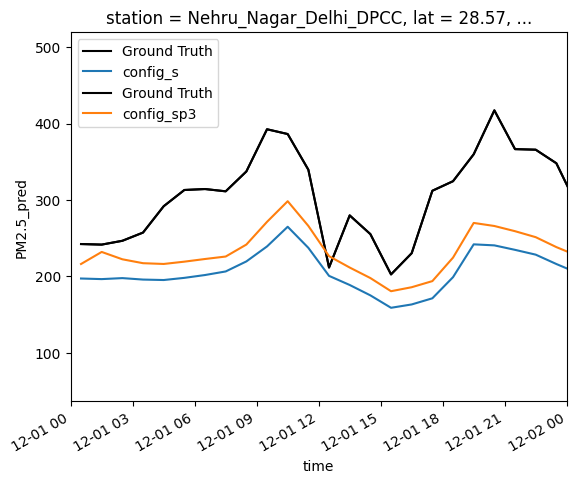

In [37]:
model = "zcnp"
fold = 0
show_df = pd.DataFrame()
fig, ax = plt.subplots()
for config in ["config_s", "config_sp3"]:
    with xr.open_dataset(f"/opt/aqmsp_models/models/{config}/{model}/cpcb_ijcai24_dec23/config1/fold_{fold}/predictions.nc") as res_ds:
        pass

    tmp_series = res_df.groupby("station").apply(lambda x: np.sqrt(np.mean((x[target] - x[f"{target}_pred"])**2)))
    # show_df[config] = tmp_series
    res_ds.sel(station="Nehru_Nagar_Delhi_DPCC")["PM2.5"].plot(ax=ax, label="Ground Truth", color="black")
    res_ds.sel(station="Nehru_Nagar_Delhi_DPCC")["PM2.5_pred"].plot(ax=ax, label=config)

# add a mean row
# show_df.loc["mean"] = show_df.mean()
# show_df
ax.legend()
ax.set_xlim(pd.Timestamp("2023-12-01"), pd.Timestamp("2023-12-02"))

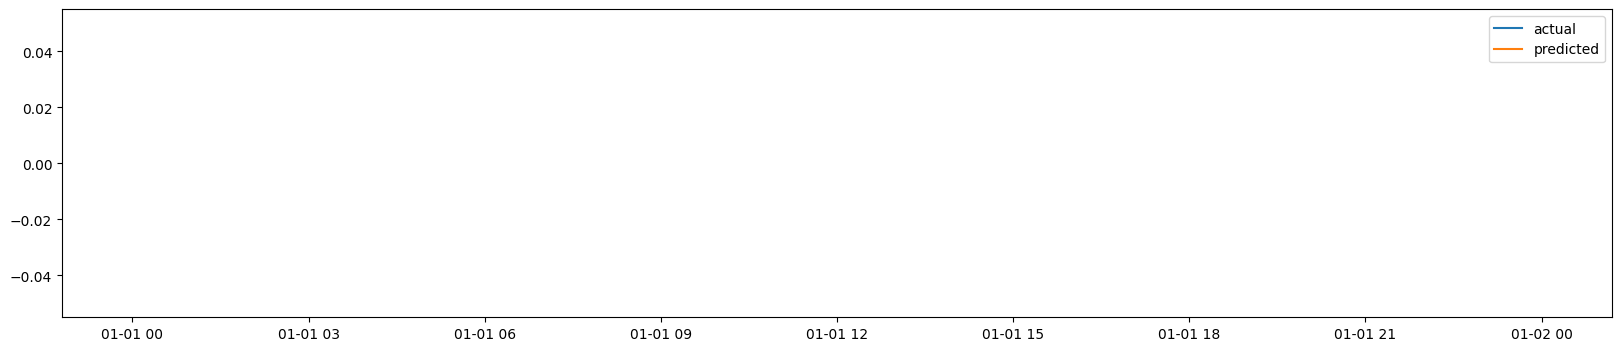

In [38]:
sdf = res_df[res_df['station'] == "Arya_Nagar_Bahadurgarh_HSPCB"]
plt.figure(figsize=(20, 4))
plt.plot(sdf['time'], sdf[target], label="actual")
plt.plot(sdf['time'], sdf[f"{target}_pred"], label="predicted")
plt.legend();

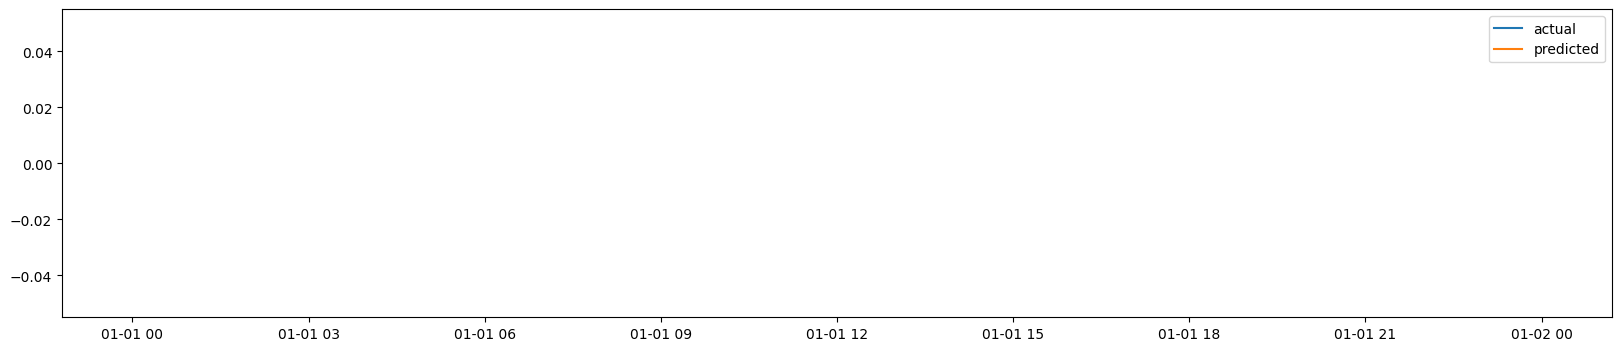

In [39]:
sdf = res_df[res_df['station'] == "Anand_Vihar_Delhi_DPCC"]
plt.figure(figsize=(20, 4))
plt.plot(sdf['time'], sdf[target], label="actual")
plt.plot(sdf['time'], sdf[f"{target}_pred"], label="predicted")
plt.legend();

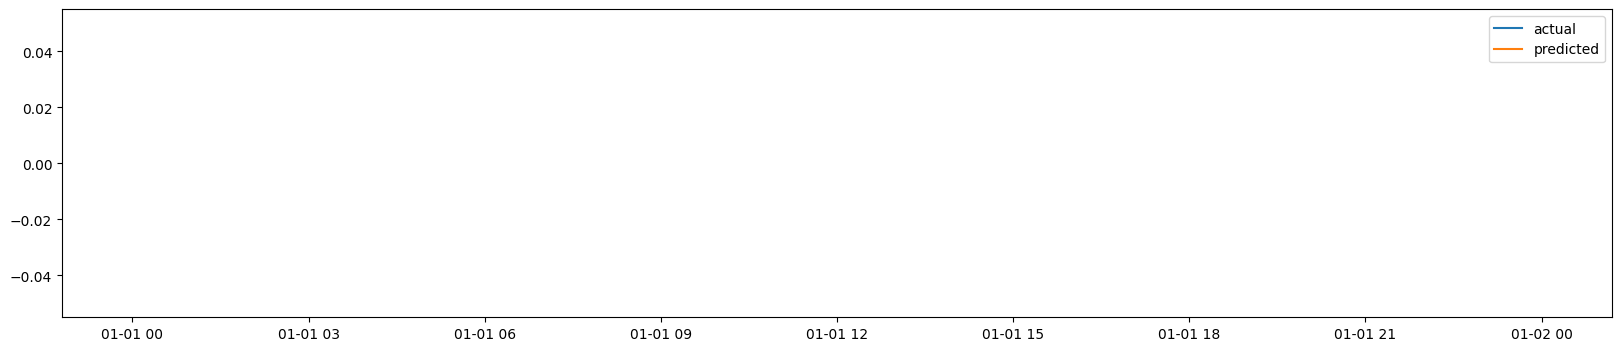

In [40]:
sdf = res_df[res_df['station'] == "Sector_2_IMT_Manesar_HSPCB"]
plt.figure(figsize=(20, 4))
plt.plot(sdf['time'], sdf[target], label="actual")
plt.plot(sdf['time'], sdf[f"{target}_pred"], label="predicted")
plt.legend();

In [41]:
res_df.groupby("station").mean()["PM2.5"].sort_values(ascending=False)

station
Nehru_Nagar_Delhi_DPCC                           268.469198
Jahangirpuri_Delhi_DPCC                          255.021057
Okhla_Phase_2_Delhi_DPCC                         214.808580
Ashok_Vihar_Delhi_DPCC                           214.691476
Major_Dhyan_Chand_National_Stadium_Delhi_DPCC    199.521505
Sirifort_Delhi_CPCB                              196.045516
Jawaharlal_Nehru_Stadium_Delhi_DPCC              191.419131
Sri_Aurobindo_Marg_Delhi_DPCC                    184.674731
North_Campus_DU_Delhi_IMD                        181.263196
Sector_62_Noida_IMD                              163.987320
Knowledge_Park_III_Greater_Noida_UPPCB           152.111895
Lodhi_Road_Delhi_IMD                             146.052536
Name: PM2.5, dtype: float64

In [42]:
with xr.open_dataset('/home/patel_zeel/aqmsp/aqmsp_data/datasets/cpcb/ijcai24/data.nc') as ds:
    pass
ds.isel(time=0).to_dataframe().reset_index()[['station', 'pop_3km']].sort_values("pop_3km", ascending=False)

,station,pop_3km
28,Punjabi_Bagh_Delhi_DPCC,1294290.0
44,Vivek_Vihar_Delhi_DPCC,1226288.0
25,North_Campus_DU_Delhi_IMD,1148846.0
38,Shadipur_Delhi_CPCB,1140568.0
45,Wazirpur_Delhi_DPCC,1084407.0
3,Ashok_Vihar_Delhi_DPCC,982964.0
24,Nehru_Nagar_Delhi_DPCC,966248.0
29,Pusa_Delhi_DPCC,965518.0
1,Anand_Vihar_Delhi_DPCC,928630.0
19,Mundka_Delhi_DPCC,907481.0


In [43]:
ds

<xarray.Dataset>
Dimensions:                    (time: 17520, station: 46)
Coordinates:
  * time                       (time) datetime64[ns] 2022-01-01T00:30:00 ... ...
  * station                    (station) object 'Alipur_Delhi_DPCC' ... 'Wazi...
    lat                        (station) float64 28.82 28.65 ... 28.67 28.7
    lon                        (station) float64 77.15 77.32 ... 77.32 77.17
    elevation                  (station) float64 232.7 228.1 ... 227.6 236.9
    pop_1km                    (station) float64 5.191e+03 ... 1.543e+05
    pop_2km                    (station) float64 2.459e+04 ... 5.677e+05
    pop_3km                    (station) float64 5.667e+04 ... 1.084e+06
    pop_4km                    (station) float64 1.033e+05 ... 1.754e+06
    pop_5km                    (station) float64 1.623e+05 ... 2.549e+06
    pop_10km                   (station) float64 1.312e+06 7.27e+06 ... 7.51e+06
    d_motorway                 (station) float64 0.09983 0.01972 ... 0.1144
Data variables: (12/417)
    TSURF_K                    (time, station) float32 ...
    SNOWEW_M                   (time, station) float32 ...
    SNOWAGE_HR                 (time, station) float32 ...
    PRATE_MMpH                 (time, station) float32 ...
    CLOUD_OD                   (time, station) float32 ...
    U10_MpS                    (time, station) float32 ...
    ...                         ...
    UWIND_MpS_LAY0_lag_1       (time, station) float32 ...
    UWIND_MpS_LAY0_lag_2       (time, station) float32 ...
    UWIND_MpS_LAY0_lag_3       (time, station) float32 ...
    UWIND_MpS_LAY0_lag_4       (time, station) float32 ...
    UWIND_MpS_LAY0_lag_5       (time, station) float32 ...
    UWIND_MpS_LAY0_lag_6       (time, station) float32 ...
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023264
    CTIME:          73659
    WDATE:          2023264
    ...             ...
    VGLVLS:         [0. 0.]
    GDNAM:          ????????????????
    UPNAM:          CAMx2IOAPI      
    VAR-LIST:       TSURF_K         SNOWEW_M        SNOWAGE_HR      PRATE_MMp...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY: